In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt


# Conectar ao banco de dados SQLite
conn = sqlite3.connect(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\seguros.db')

df_dict = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_dicionario_dados.csv', encoding='utf-8', sep=',')
df_cancel = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_cancelamentos.csv', encoding='utf-8', sep=',')
df_contratos = pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_contratos.csv', encoding='utf-8', sep=',')
df_clientes= pd.read_csv(r'C:\Users\Usuario\OneDrive\Documentos\final-project\final-project\data\P18_clientes.csv', encoding='utf-8', sep=',')
df_clientes.to_sql('clientes', conn, if_exists='replace', index=False)
df_contratos.to_sql('contratos', conn, if_exists='replace', index=False)
df_cancel.to_sql('cancelamentos', conn, if_exists='replace', index=False)

# Carregar as tabelas como DataFrames do pandas
df_clientes = pd.read_sql_query("SELECT * FROM clientes", conn)
df_contratos = pd.read_sql_query("SELECT * FROM contratos", conn)
df_cancel = pd.read_sql_query("SELECT * FROM cancelamentos", conn)



In [3]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente, -- pega a string a partir do 2º caractere
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,
  
  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)

df



,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,duracao_dias,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,180.0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,730.0,Bianual,0
2,Outro,39,19063.54,Técnico,0,Vida,511.69,Baixa,App,0,180.0,Semestral,0
3,Feminino,79,13716.90,Superior,1,Residencial,417.14,Baixa,Corretor,0,365.0,Anual,0
4,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,180.0,Semestral,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,180.0,Semestral,1
11996,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,730.0,Bianual,0
11997,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,730.0,Bianual,1
11998,Masculino,42,4596.17,Superior,1,Vida,1026.34,Alta,App,1,180.0,Semestral,0


### 1. Categorizando colunas

Primeiro irei começar categorizando algumas colunas para que o modelo possa identificar melhor os padrões.

In [92]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop("cancelado", axis=1)
y = df["cancelado"]


categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder()

#Usando ColumnTransformer para aplicar o One-Hot apenas nas colunas categóricas
transformer = ColumnTransformer([("one_hot", # name
                                  one_hot, # transformer
                                  categorical_features)], # columns to transform
                                  remainder="passthrough") # what to do with the rest of the columns? ("passthrough" = leave unchanged) 

# 5. Turn the categorical features into numbers (this will return an array-like sparse matrix, not a DataFrame)
transformed_X = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Fit the model on the numerical data (this errored before since our data wasn't fully numeric)
model.score(X_test, y_test)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1861
           1       0.17      0.00      0.00       539

    accuracy                           0.77      2400
   macro avg       0.47      0.50      0.44      2400
weighted avg       0.64      0.77      0.68      2400

[[1856    5]
 [ 538    1]]


Esse modelo ta um lixo

Este modelo está desbalanceado, abaixo será realizado tratativas para ter uma boa precisão

In [94]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

X = df.drop("cancelado", axis=1)
y = df["cancelado"]


categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder()

#Usando ColumnTransformer para aplicar o One-Hot apenas nas colunas categóricas
transformer = ColumnTransformer([("one_hot", # name
                                  one_hot, # transformer
                                  categorical_features)], # columns to transform
                                  remainder="passthrough") # what to do with the rest of the columns? ("passthrough" = leave unchanged) 

# 5. Turn the categorical features into numbers (this will return an array-like sparse matrix, not a DataFrame)
transformed_X = transformer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(transformed_X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("🧩 Matriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)


print(cm)

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1861
           1       0.00      0.00      0.00       539

    accuracy                           0.77      2400
   macro avg       0.39      0.50      0.44      2400
weighted avg       0.60      0.77      0.68      2400

🧩 Matriz de Confusão:
[[1857    4]
 [ 539    0]]


Outro lixo

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.99      0.88      1897
           1       0.99      0.74      0.85      1895

    accuracy                           0.87      3792
   macro avg       0.89      0.87      0.86      3792
weighted avg       0.89      0.87      0.86      3792

[[1882   15]
 [ 491 1404]]


### 1. Remover contratos expirados sem cancelamento da análise
---
- Os contratos já terminaram, mas não foram cancelados - ou seja, eles saíram do sistema no prazo previsto
- Esses dados podem confundir o modelo, porque não representam clientes que cancelaram antes do fim natural.

Query de Contratos Ativos

In [4]:
query_total_contratos_ativos = """
SELECT COUNT(*) AS total_contratos_ativos
FROM contratos c
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato
WHERE ca.id_contrato IS NULL  -- contrato não cancelado
  AND DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df_total_contratos_ativos = pd.read_sql_query(query_total_contratos_ativos, conn)
df_total_contratos_ativos

,total_contratos_ativos
0,3624


Query de contratos inativos X cancelados

In [7]:
query_total_contratos_inativos_cancelados = """
SELECT 
  SUM(CASE WHEN ca.id_contrato IS NOT NULL THEN 1 ELSE 0 END) AS total_cancelados,
  SUM(CASE 
        WHEN ca.id_contrato IS NULL AND DATE('now') > DATE(c.data_fim) 
        THEN 1 
        ELSE 0 
      END) AS total_expirados_sem_cancelamento,
  COUNT(*) AS total_inativos
FROM contratos c
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato
WHERE 
  ca.id_contrato IS NOT NULL  -- cancelado
  OR DATE('now') > DATE(c.data_fim)  -- expirado
;
"""
df_total_contratos_inativos_cancelados = pd.read_sql_query(query_total_contratos_inativos_cancelados, conn)
df_total_contratos_inativos_cancelados

,total_cancelados,total_expirados_sem_cancelamento,total_inativos
0,2520,5856,8376


#### Selecionando contratos ativos e cancelados para aplicar o modelo de Machine Learning para prever churn

In [12]:
query = """ 
SELECT
  substr(c.id_cliente, 2) AS id_cliente,
  cl.genero,
  cl.data_nascimento,
  CAST(strftime('%Y', 'now') AS INTEGER) - CAST(strftime('%Y', cl.data_nascimento) AS INTEGER) AS idade,
  cl.renda_mensal,
  cl.nivel_educacional,
  cl.qtd_dependentes,
  c.tipo_seguro,
  c.valor_premio_mensal,
  c.satisfacao_ultima_avaliacao,
  c.canal_venda,
  c.renovado_automaticamente,
  ca.motivo_cancelamento,
  DATE(c.data_inicio) AS inicio,
  DATE(c.data_fim) AS fim,
  julianday(c.data_fim) - julianday(c.data_inicio) AS duracao_dias,

  CASE 
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) <= 31 THEN 'Mensal'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 32 AND 92 THEN 'Trimestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 93 AND 183 THEN 'Semestral'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) BETWEEN 184 AND 366 THEN 'Anual'
    WHEN julianday(c.data_fim) - julianday(c.data_inicio) > 366 THEN 'Bianual'
    ELSE 'Indefinido'
  END AS tipo_duracao,

  CASE 
    WHEN ca.id_contrato IS NOT NULL THEN 1
    ELSE 0
  END AS cancelado

FROM contratos c
JOIN clientes cl ON c.id_cliente = cl.id_cliente
LEFT JOIN cancelamentos ca ON c.id_contrato = ca.id_contrato

-- ✅ Mantém apenas contratos ativos ou cancelados
WHERE ca.id_contrato IS NOT NULL
   OR DATE('now') BETWEEN DATE(c.data_inicio) AND DATE(c.data_fim)
;

"""
df = pd.read_sql_query(query, conn)
df['id_cliente'] = df['id_cliente'].astype(int)
df = df.drop('data_nascimento', axis=1)
df = df.drop('id_cliente', axis=1)
df = df.drop('motivo_cancelamento', axis=1)
df = df.drop('inicio', axis=1)
df = df.drop('fim', axis=1)
df = df.drop('duracao_dias', axis=1)


df


,genero,idade,renda_mensal,nivel_educacional,qtd_dependentes,tipo_seguro,valor_premio_mensal,satisfacao_ultima_avaliacao,canal_venda,renovado_automaticamente,tipo_duracao,cancelado
0,Outro,66,12406.88,Técnico,2,Empresarial,892.30,Média,Site,0,Semestral,1
1,Outro,67,18950.78,Superior,3,Vida,962.07,Baixa,Agência Física,0,Bianual,0
2,Feminino,46,17135.37,Técnico,3,Vida,996.09,Baixa,App,1,Semestral,1
3,Masculino,77,13945.07,Pós,2,Saúde,1158.48,Baixa,Site,1,Bianual,0
4,Masculino,19,11315.19,Superior,0,Vida,840.08,Média,Site,1,Anual,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6139,Masculino,19,15801.76,Fundamental,0,Vida,599.48,Alta,Agência Física,1,Bianual,1
6140,Masculino,57,3167.47,Superior,1,Residencial,334.17,Baixa,Agência Física,0,Semestral,1
6141,Outro,45,1655.74,Médio,1,Vida,897.26,Alta,Site,0,Bianual,0
6142,Outro,45,16652.42,Médio,0,Vida,1478.74,Alta,Agência Física,0,Bianual,1


## RandomForestClassifier | Ótimo modelo

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE

# 1. Prepara os dados
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Codificação das variáveis categóricas
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
encoder = ColumnTransformer(
    [("onehot", OneHotEncoder(drop="first"), categorical_features)],
    remainder="passthrough"
)

X_encoded = encoder.fit_transform(X)

# 3. Aplica o SMOTE para balancear a base
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

# 4. Divide os dados balanceados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 5. Treina o modelo RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 6. Avalia o modelo
y_pred = model.predict(X_test)

print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print(cm)



📊 Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.82      0.72       703
           1       0.77      0.58      0.66       747

    accuracy                           0.70      1450
   macro avg       0.71      0.70      0.69      1450
weighted avg       0.71      0.70      0.69      1450

[[576 127]
 [313 434]]


#### Primeiro Modelo

In [14]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define as colunas categóricas e o transformador
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"]
one_hot = OneHotEncoder(sparse_output=False)
  # use sparse=False para garantir numpy array denso
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)

# 3. Transforma os dados categóricos
transformed_X = transformer.fit_transform(X)

# 4. Divide treino e teste (sem SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, test_size=0.25, random_state=42
)

# 5. Treina o modelo com pesos balanceados
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Melhores parâmetros:", grid_search.best_params_)

# Usa o melhor modelo para predizer e avaliar
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


probs = best_model.predict_proba(X_test)[:, 1]

# Importações para o ajuste do threshold e plot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Calcula precisão, recall e thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

# Plota precisão e recall em função do threshold

# Escolha seu threshold com base no gráfico
chosen_threshold = 0.40  # ajuste aqui

# Previsões ajustadas pelo threshold
y_pred_adj = (probs >= chosen_threshold).astype(int)
print("--------------------------")
# Avalia resultados
print(f"Relatório com threshold = {chosen_threshold}")
print(classification_report(y_test, y_pred_adj))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_adj))
import pandas as pd

# Converte o X_test numpy array em DataFrame, para facilitar análise
df_resultado = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())

# Adiciona as colunas y_real e y_pred
df_resultado["y_real"] = y_test.reset_index(drop=True)
df_resultado["y_pred"] = y_pred

# Filtra falsos positivos
falsos_positivos = df_resultado[(df_resultado["y_real"] == 0) & (df_resultado["y_pred"] == 1)]

print(f"Total falsos positivos: {len(falsos_positivos)}")
df_scores = pd.DataFrame({
    "prob_cancelamento": probs,
    "y_real": y_test.reset_index(drop=True)
})

df_scores = df_scores.sort_values(by="prob_cancelamento", ascending=False)




Melhores parâmetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       892
           1       0.58      0.56      0.57       644

    accuracy                           0.65      1536
   macro avg       0.64      0.63      0.63      1536
weighted avg       0.64      0.65      0.65      1536

[[634 258]
 [285 359]]
--------------------------
Relatório com threshold = 0.4
              precision    recall  f1-score   support

           0       0.73      0.49      0.59       892
           1       0.52      0.75      0.61       644

    accuracy                           0.60      1536
   macro avg       0.62      0.62      0.60      1536
weighted avg       0.64      0.60      0.60      1536

Matriz de confusão:
[[440 452]
 [161 483]]
Total falsos positivos: 258


>MEIA BOCA MAS POSSIVEL APLICAR SMOTE

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from scipy.stats import uniform, randint

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define as colunas categóricas e o transformador
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)

# 3. Transforma os dados categóricos
transformed_X = transformer.fit_transform(X)

# 4. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, test_size=0.20, random_state=42
)

# 5. Calcula scale_pos_weight para balancear classes no XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# 6. Define distribuição dos hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [scale_pos_weight * 0.8, scale_pos_weight, scale_pos_weight * 1.2]
}

# 7. Inicializa o modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 8. Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# 9. Executa a busca de hiperparâmetros
random_search.fit(X_train, y_train)

print("Melhores parâmetros:", random_search.best_params_)

# 10. Usa o melhor modelo para predizer e avaliar
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

import pandas as pd

# Converte o X_test numpy array em DataFrame, para facilitar análise
df_resultado = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())

# Adiciona as colunas y_real e y_pred
df_resultado["y_real"] = y_test.reset_index(drop=True)
df_resultado["y_pred"] = y_pred

# Filtra falsos positivos
falsos_positivos = df_resultado[(df_resultado["y_real"] == 0) & (df_resultado["y_pred"] == 1)]

print(f"Total falsos positivos: {len(falsos_positivos)}")



c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:51:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'colsample_bytree': np.float64(0.8832290311184181), 'learning_rate': np.float64(0.014116898859160489), 'max_depth': 4, 'n_estimators': 137, 'scale_pos_weight': 1.4525948103792414, 'subsample': np.float64(0.6849356442713105)}
              precision    recall  f1-score   support

           0       0.71      0.64      0.67       713
           1       0.56      0.63      0.59       516

    accuracy                           0.64      1229
   macro avg       0.63      0.63      0.63      1229
weighted avg       0.64      0.64      0.64      1229

[[455 258]
 [190 326]]
Total falsos positivos: 258


## Tendando melhorar o desempenho do Modelo

### MODELO XGBOOST

c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:51:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'colsample_bytree': np.float64(0.8832290311184181), 'learning_rate': np.float64(0.014116898859160489), 'max_depth': 4, 'n_estimators': 137, 'scale_pos_weight': 1.4525948103792414, 'subsample': np.float64(0.6849356442713105)}


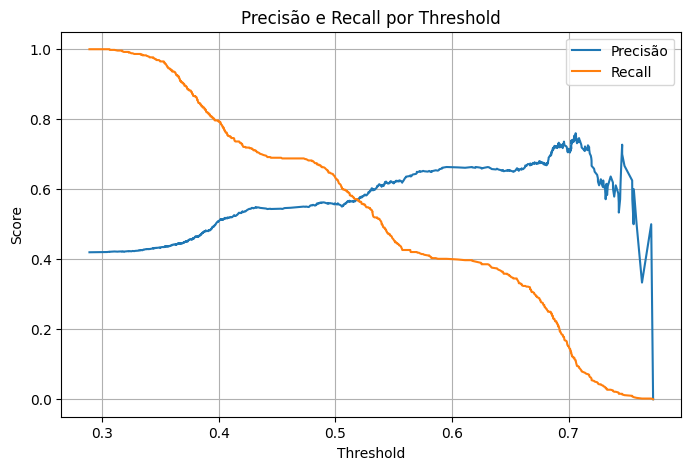

Relatório com threshold = 0.35
              precision    recall  f1-score   support

           0       0.77      0.09      0.15       713
           1       0.43      0.97      0.60       516

    accuracy                           0.45      1229
   macro avg       0.60      0.53      0.38      1229
weighted avg       0.63      0.45      0.34      1229

Matriz de confusão:
[[ 61 652]
 [ 18 498]]
Total falsos positivos: 258
      prob_cancelamento  y_real
264            0.310499       1
1116           0.309085       0
133            0.307220       0
1075           0.306552       0
699            0.306222       1
165            0.306096       0
132            0.305362       0
58             0.304052       0
617            0.299715       0
1058           0.289066       0


In [16]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from scipy.stats import uniform, randint

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define as colunas categóricas e o transformador
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)

# 3. Transforma os dados categóricos
transformed_X = transformer.fit_transform(X)

# 4. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, test_size=0.20, random_state=42
)

# 5. Calcula scale_pos_weight para balancear classes no XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

# 6. Define distribuição dos hiperparâmetros para RandomizedSearchCV
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'scale_pos_weight': [scale_pos_weight * 0.8, scale_pos_weight, scale_pos_weight * 1.2]
}

# 7. Inicializa o modelo XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# 8. Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# 9. Executa a busca de hiperparâmetros
random_search.fit(X_train, y_train)

print("Melhores parâmetros:", random_search.best_params_)

# 10. Usa o melhor modelo para predizer e avaliar
probs = best_model.predict_proba(X_test)[:, 1]

# Importações para o ajuste do threshold e plot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Calcula precisão, recall e thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

# Plota precisão e recall em função do threshold
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions[:-1], label="Precisão")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precisão e Recall por Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Escolha seu threshold com base no gráfico
chosen_threshold = 0.35  # ajuste aqui

# Previsões ajustadas pelo threshold
y_pred_adj = (probs >= chosen_threshold).astype(int)

# Avalia resultados
print(f"Relatório com threshold = {chosen_threshold}")
print(classification_report(y_test, y_pred_adj))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_adj))
import pandas as pd

# Converte o X_test numpy array em DataFrame, para facilitar análise
df_resultado = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())

# Adiciona as colunas y_real e y_pred
df_resultado["y_real"] = y_test.reset_index(drop=True)
df_resultado["y_pred"] = y_pred

# Filtra falsos positivos
falsos_positivos = df_resultado[(df_resultado["y_real"] == 0) & (df_resultado["y_pred"] == 1)]

print(f"Total falsos positivos: {len(falsos_positivos)}")
df_scores = pd.DataFrame({
    "prob_cancelamento": probs,
    "y_real": y_test.reset_index(drop=True)
})

df_scores = df_scores.sort_values(by="prob_cancelamento", ascending=False)

print(df_scores.tail(10))


Com o threshold ele está marcando todos como probabilidade de cancelamento, existem muitos falsos positivos.
Aplicando uma probabilidade de cancelamento, conseguimos ver que alguns tem apenas 6% de chance de realmente cancelar.

>Possível aplicar o SMOTE nesse modelo para ver se desempenha melhor

> O objetivo agora é melhorar o modelo para que ele identifique casos reais de clientes que realmente tem probabilidade de cancelar. Vou aplicar SHAP para identificar as variáveis que tem peso maior que fazem o cliente cancelar.

#### Utilizando LightGBM

In [17]:
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
import pandas as pd

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define as colunas categóricas e o transformador
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)

# 3. Transforma os dados categóricos
transformed_X = transformer.fit_transform(X)

# 4. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, test_size=0.25, random_state=42
)

# 5. Calcula scale_pos_weight para balancear classes no XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

lgb_model = lgb.LGBMClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
# 6. Define distribuição dos hiperparâmetros para RandomizedSearchCV
param_dist = {
    'num_leaves': randint(20,150),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha':uniform(0,1),
    'reg_lambda':uniform(0,1),
}


# 7. Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# 9. Executa a busca de hiperparâmetros
random_search.fit(X_train, y_train)

print("Melhores parâmetros:", random_search.best_params_)

# 9. Avalia com o melhor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:52:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "num_leaves", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'colsample_bytree': np.float64(0.9792707484415992), 'learning_rate': np.float64(0.26414294322867693), 'max_depth': 3, 'n_estimators': 248, 'num_leaves': 47, 'reg_alpha': np.float64(0.9500619670508049), 'reg_lambda': np.float64(0.9506071469375561), 'subsample': np.float64(0.7867189440616431)}
              precision    recall  f1-score   support

           0       0.66      0.75      0.71       892
           1       0.58      0.47      0.52       644

    accuracy                           0.63      1536
   macro avg       0.62      0.61      0.61      1536
weighted avg       0.63      0.63      0.63      1536

[[672 220]
 [342 302]]


#### Utilizando Threshold

In [18]:
import lightgbm as lgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import uniform, randint
import pandas as pd

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define as colunas categóricas e o transformador
categorical_features = ["genero", "nivel_educacional", "tipo_seguro", "satisfacao_ultima_avaliacao", "canal_venda","tipo_duracao"]
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)

# 3. Transforma os dados categóricos
transformed_X = transformer.fit_transform(X)

# 4. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    transformed_X, y, test_size=0.25, random_state=42
)




# 5. Calcula scale_pos_weight para balancear classes no XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

lgb_model = lgb.LGBMClassifier(random_state=42, is_unbalance = True,  scale_pos_weight=scale_pos_weight)
# 6. Define distribuição dos hiperparâmetros para RandomizedSearchCV
param_dist = {
    'num_leaves': randint(20,150),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha':uniform(0,1),
    'reg_lambda':uniform(0,1),
}


# 7. Configura RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=100,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    random_state=42
)

# 9. Executa a busca de hiperparâmetros
random_search.fit(X_train, y_train)

print("Melhores parâmetros:", random_search.best_params_)

# 9. Avalia com o melhor modelo
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

probs = best_model.predict_proba(X_test)[:, 1]

# Importações para o ajuste do threshold e plot
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix

# Calcula precisão, recall e thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, probs)

# Plota precisão e recall em função do threshold

# Escolha seu threshold com base no gráfico
chosen_threshold = 0.15  # ajuste aqui

# Previsões ajustadas pelo threshold
y_pred_adj = (probs >= chosen_threshold).astype(int)
print("--------------------------")
# Avalia resultados
print(f"Relatório com threshold = {chosen_threshold}")
print(classification_report(y_test, y_pred_adj))
print("Matriz de confusão:")
print(confusion_matrix(y_test, y_pred_adj))
import pandas as pd

# Converte o X_test numpy array em DataFrame, para facilitar análise
df_resultado = pd.DataFrame(X_test, columns=transformer.get_feature_names_out())

# Adiciona as colunas y_real e y_pred
df_resultado["y_real"] = y_test.reset_index(drop=True)
df_resultado["y_pred"] = y_pred

# Filtra falsos positivos
falsos_positivos = df_resultado[(df_resultado["y_real"] == 0) & (df_resultado["y_pred"] == 1)]

print(f"Total falsos positivos: {len(falsos_positivos)}")
df_scores = pd.DataFrame({
    "prob_cancelamento": probs,
    "y_real": y_test.reset_index(drop=True)
})

df_scores = df_scores.sort_values(by="prob_cancelamento", ascending=False)




c:\Users\Usuario\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:52:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "num_leaves", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Melhores parâmetros: {'colsample_bytree': np.float64(0.9792707484415992), 'learning_rate': np.float64(0.26414294322867693), 'max_depth': 3, 'n_estimators': 248, 'num_leaves': 47, 'reg_alpha': np.float64(0.9500619670508049), 'reg_lambda': np.float64(0.9506071469375561), 'subsample': np.float64(0.7867189440616431)}
              precision    recall  f1-score   support

           0       0.66      0.75      0.71       892
           1       0.58      0.47      0.52       644

    accuracy                           0.63      1536
   macro avg       0.62      0.61      0.61      1536
weighted avg       0.63      0.63      0.63      1536

[[672 220]
 [342 302]]
--------------------------
Relatório com threshold = 0.15
              precision    recall  f1-score   support

           0       0.74      0.09      0.16       892
           1       0.43      0.95      0.59       644

    accuracy                           0.45      1536
   macro avg       0.59      0.52      0.38      1536
weigh

Bom resultado

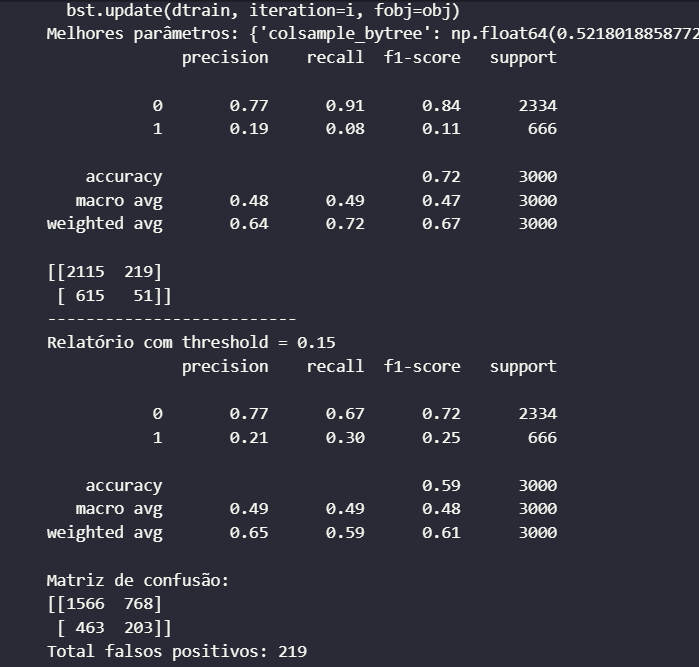

#### Utilizando CatBoost

In [19]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# 1. Define X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Lista das colunas categóricas (nomes)
cat_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4. Como CatBoost lida com categóricas internamente, não precisa OneHot. 
# Porém, SMOTE precisa de dados numéricos, então vamos transformar categoricas para códigos numericos.

for col in cat_features:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

# 5. Aplica SMOTE (agora com dados numéricos)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 6. Cria Pool para CatBoost, indicando as colunas categóricas pelos índices
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]
train_pool = Pool(X_train_smote, y_train_smote, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

# 7. Inicializa e treina o modelo CatBoost
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    eval_metric='AUC',
    random_seed=42,
    verbose=100,
    class_weights=[1, y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]]
)
model.fit(train_pool)



# 8. Faz previsões probabilísticas
y_proba = model.predict_proba(test_pool)[:, 1]

# 9. Ajusta threshold manualmente (exemplo: 0.3)
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

# 10. Avaliação
print(f"Relatório com threshold = {threshold}\n")
print(classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))


0:	total: 197ms	remaining: 1m 38s
100:	total: 4.38s	remaining: 17.3s
200:	total: 8.71s	remaining: 13s
300:	total: 13s	remaining: 8.58s
400:	total: 17.4s	remaining: 4.28s
499:	total: 21.8s	remaining: 0us
Relatório com threshold = 0.5

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       906
           1       0.50      0.50      0.50       630

    accuracy                           0.59      1536
   macro avg       0.57      0.57      0.57      1536
weighted avg       0.59      0.59      0.59      1536

Matriz de confusão:
 [[586 320]
 [316 314]]


Evidência: 0.3 
Matriz de confusão:
 [[1145 1225]
 [ 314  316]]
50% de acerto mas muitos falsos positivos 50% também

Evidência: 0.2
Matriz de confusão:
 [[ 682 1688]
 [ 178  452]]
Bom resultados encontrados os cancelados mas muitos falsos positivos

Evidência: 0.4
Matriz de confusão:
 [[1515  855]
 [ 400  230]]
Acertou 30% mais ou menos, mas há muitos falsos positivos

Evidência: 0.5
Matriz de confusão:
 [[1818  552]
 [ 471  159]]
Uma merda

### Utilizando SMOTE

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define colunas categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. One-hot encoding
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)
X_transformed = transformer.fit_transform(X)

# 4. Divide treino e teste (antes do SMOTE!)
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.25, random_state=42
)

# 5. Aplica SMOTE somente nos dados de treino
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


# 6. Treina modelo (sem GridSearch, direto)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_smote, y_train_smote)

# 7. Avalia
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.67      0.79      0.73       892
           1       0.61      0.47      0.53       644

    accuracy                           0.65      1536
   macro avg       0.64      0.63      0.63      1536
weighted avg       0.65      0.65      0.64      1536

[[703 189]
 [343 301]]


In [22]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define colunas categóricas
categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. One-hot encoding
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)
X_transformed = transformer.fit_transform(X)

# 4. Divide em treino e teste (antes do SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.25, random_state=42
)

# 5. Aplica SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Verifica balanceamento
print("Distribuição após SMOTE:", dict(zip(*np.unique(y_train_smote, return_counts=True))))

# 6. Treina RandomForest com class_weight
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_smote, y_train_smote)

# 7. Probabilidades no teste
y_proba = model.predict_proba(X_test)[:, 1]

# 8. Aplica THRESHOLD manual (ex: 0.3)
threshold = 0.2
y_pred_custom = (y_proba >= threshold).astype(int)

# 9. Avaliação
print(f"\n🔎 Avaliação com threshold = {threshold}")
print(classification_report(y_test, y_pred_custom))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_custom))
print("Total falsos positivos:", np.sum((y_pred_custom == 1) & (y_test == 0)))


Distribuição após SMOTE: {np.int64(0): np.int64(2732), np.int64(1): np.int64(2732)}

🔎 Avaliação com threshold = 0.2
              precision    recall  f1-score   support

           0       0.72      0.08      0.14       892
           1       0.43      0.96      0.59       644

    accuracy                           0.45      1536
   macro avg       0.57      0.52      0.36      1536
weighted avg       0.60      0.45      0.33      1536

Matriz de confusão:
 [[ 67 825]
 [ 26 618]]
Total falsos positivos: 825


In [23]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

# 👉 Define variáveis
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

categorical_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda",
]

# One-hot transformer
one_hot = OneHotEncoder(sparse_output=False)
transformer = ColumnTransformer(
    [("one_hot", one_hot, categorical_features)],
    remainder="passthrough"
)
X_transformed = transformer.fit_transform(X)

# ✂️ Divide em treino/teste uma única vez para manter a comparação justa
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X_transformed, y, test_size=0.25, random_state=42
)

# ------------------------
# 🔹 1. Sem Balanceamento
# ------------------------
model_original = RandomForestClassifier(class_weight='balanced', random_state=42)
model_original.fit(X_train_full, y_train_full)
y_pred_orig = model_original.predict(X_test)

print("🔹 [1] SEM BALANCEAMENTO")
print(classification_report(y_test, y_pred_orig))
print("Matriz:", confusion_matrix(y_test, y_pred_orig), "\n")

# ------------------------
# 🔹 2. SMOTE
# ------------------------
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_full, y_train_full)

model_smote = RandomForestClassifier(class_weight='balanced', random_state=42)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test)

print("🔹 [2] COM SMOTE")
print(classification_report(y_test, y_pred_smote))
print("Matriz:", confusion_matrix(y_test, y_pred_smote), "\n")

# ------------------------
# 🔹 3. Balanceamento Manual
# ------------------------
# Junta dados de treino originais
df_treino = pd.DataFrame(X_train_full)
df_treino["cancelado"] = y_train_full.values

cancelados = df_treino[df_treino["cancelado"] == 1]
ativos = df_treino[df_treino["cancelado"] == 0].sample(n=len(cancelados), random_state=42)

df_bal_manual = pd.concat([cancelados, ativos]).sample(frac=1, random_state=42)

X_train_manual = df_bal_manual.drop("cancelado", axis=1)
y_train_manual = df_bal_manual["cancelado"]

model_manual = RandomForestClassifier(class_weight='balanced', random_state=42)
model_manual.fit(X_train_manual, y_train_manual)
y_pred_manual = model_manual.predict(X_test)

print("🔹 [3] BALANCEAMENTO MANUAL (2520x2520)")
print(classification_report(y_test, y_pred_manual))
print("Matriz:", confusion_matrix(y_test, y_pred_manual))


ValueError: could not convert string to float: 'Bianual'

🔍 Rodando Grid Search com validação cruzada...
Training on fold [0/3]

bestTest = 0.7204691315
bestIteration = 278

Training on fold [1/3]

bestTest = 0.6655044369
bestIteration = 224

Training on fold [2/3]

bestTest = 0.6916034384
bestIteration = 297

Training on fold [0/3]

bestTest = 0.7190669025
bestIteration = 64

Training on fold [1/3]

bestTest = 0.670658938
bestIteration = 165

Training on fold [2/3]

bestTest = 0.6891059846
bestIteration = 105

Training on fold [0/3]

bestTest = 0.7204691315
bestIteration = 278

Training on fold [1/3]

bestTest = 0.6655044369
bestIteration = 224

Training on fold [2/3]

bestTest = 0.6918434377
bestIteration = 307

Training on fold [0/3]

bestTest = 0.7190669025
bestIteration = 64

Training on fold [1/3]

bestTest = 0.670658938
bestIteration = 165

Training on fold [2/3]

bestTest = 0.6891059846
bestIteration = 105

Training on fold [0/3]

bestTest = 0.7188378677
bestIteration = 142

Training on fold [1/3]

bestTest = 0.6697854383
bestIteratio

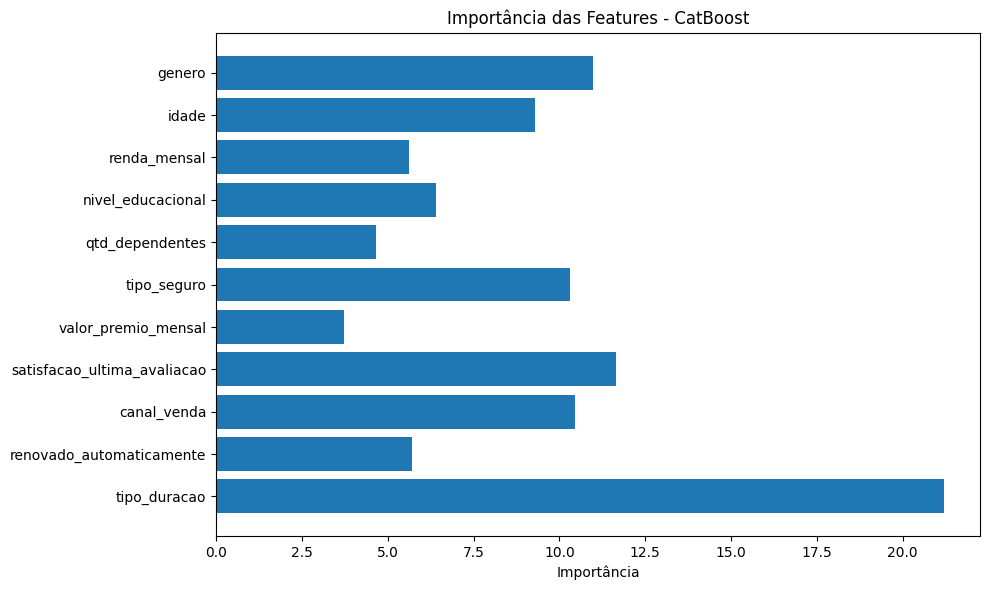

In [24]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Divide X e y
X = df.drop("cancelado", axis=1)
y = df["cancelado"]

# 2. Define colunas categóricas
cat_features = [
    "genero", "nivel_educacional", "tipo_seguro",
    "satisfacao_ultima_avaliacao", "canal_venda", "tipo_duracao"
]

# 3. Divide treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# 4. Transforma categóricas para números (SMOTE precisa)
for col in cat_features:
    X_train[col] = X_train[col].astype('category').cat.codes
    X_test[col] = X_test[col].astype('category').cat.codes

# 5. Aplica SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 6. Cria Pool
cat_feature_indices = [X_train.columns.get_loc(col) for col in cat_features]
train_pool = Pool(X_train_smote, y_train_smote, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

# 7. Grid Search com validação cruzada
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.03, 0.1],
    'iterations': [300, 500]
}

grid = list(ParameterGrid(param_grid))
resultados = []

print("🔍 Rodando Grid Search com validação cruzada...")
for params in grid:
    full_params = params | {
        'eval_metric': 'AUC',
        'loss_function': 'Logloss'
    }

    cv_result = cv(
        Pool(X_train_smote, y_train_smote, cat_features=cat_feature_indices),
        full_params,
        fold_count=3,
        shuffle=True,
        partition_random_seed=42,
        stratified=True,
        verbose=False,
        early_stopping_rounds=30
    )

    best_auc = np.max(cv_result["test-AUC-mean"])
    resultados.append((params, best_auc))

# Ordena por melhor AUC
resultados.sort(key=lambda x: x[1], reverse=True)
print("\n✅ Top 3 combinações:")
for r in resultados[:3]:
    print(r)

# 8. Treina o melhor modelo
melhores_param = resultados[0][0]
model_final = CatBoostClassifier(
    **melhores_param,
    random_seed=42,
    verbose=100,
    class_weights=[1, y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]]
)
model_final.fit(train_pool)

# 9. Avaliação em múltiplos thresholds
y_proba = model_final.predict_proba(test_pool)[:, 1]
thresholds = np.arange(0.2, 0.51, 0.05)

print("\n📊 Avaliação de thresholds:")
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred)
    r = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1:.2f}")

# 10. Threshold ideal (exemplo 0.3)
final_threshold = 0.3
y_pred_final = (y_proba >= final_threshold).astype(int)

print(f"\n🧾 Relatório final com threshold = {final_threshold}")
print(classification_report(y_test, y_pred_final))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred_final))

# 11. Importância das Features
importances = model_final.get_feature_importance()
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.title("Importância das Features - CatBoost")
plt.xlabel("Importância")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
